In [3]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy.io as spio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from modules import optimize_ML, optimize_ELBO

import os

In [4]:
# load sample trajectory
sim_idx = 0 # which out of the 100 trajectories to use
data_path = Path('data')
f_name = 'sim_0132.mat'
S = spio.loadmat(Path(data_path) / f_name)['S']
S_list = [S[0, i] for i in range(S.shape[1])]  # convert to list of structs

# unpack data
n_corr_obs = S_list[sim_idx]['Pc_reshaped'][0, 0] * S_list[sim_idx]['num_trials_mat'][0, 0]
n_total_obs = S_list[sim_idx]['num_trials_mat'][0, 0]
n_frames = S_list[sim_idx]['Pc_reshaped'][0, 0].shape[0]
n_dim = S_list[sim_idx]['x'][0, 0].shape[0]

x, c_est, p, c, d, a, mu_prior_c, mu_post_c = optimize_ELBO(n_dim, n_corr_obs, n_total_obs, verbose=True, n_starts=10)

Running MLE to initialize posterior..........................
Current loss: 277.2092297896743
Loss updated
Iteration 1 | Loss: 277.2092297896743
Current loss: 292.04099597781897
Iteration 2 | Loss: 292.04099597781897
Current loss: 373.60855177789927
Iteration 3 | Loss: 373.60855177789927
Current loss: 328.0961403399706
Iteration 4 | Loss: 328.0961403399706
Current loss: 316.5314976796508
Iteration 5 | Loss: 316.5314976796508
Current loss: 361.9761161580682
Iteration 6 | Loss: 361.9761161580682
Current loss: 355.93598426133394
Iteration 7 | Loss: 355.93598426133394
Current loss: 323.5705567598343
Iteration 8 | Loss: 323.5705567598343
Current loss: 452.1968831270933
Iteration 9 | Loss: 452.1968831270933
Current loss: 377.2028218358755
Iteration 10 | Loss: 377.2028218358755

Start minimizing ELBO..........................


KeyboardInterrupt: 

In [ ]:
est_global_curvature = np.rad2deg(mu_prior_c.detach().numpy())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {np.rad2deg(torch.mean(c).detach().numpy())} degrees')

Estimated global curvature: 60.0 degrees
Average estimated local curvature: 38.80104064941406 degrees


In [ ]:
# compute PC-reduced perceptual locations
pca_true = PCA(n_components=2)
pca_fit = PCA(n_components=2)

# ground truth perceptual locations
pca_true.fit(S_list[sim_idx]['x'][0, 0])
pc_true = pca_true.components_

pca_fit.fit(torch.mean(x, dim=0).squeeze().detach())
pc_fit = pca_fit.components_

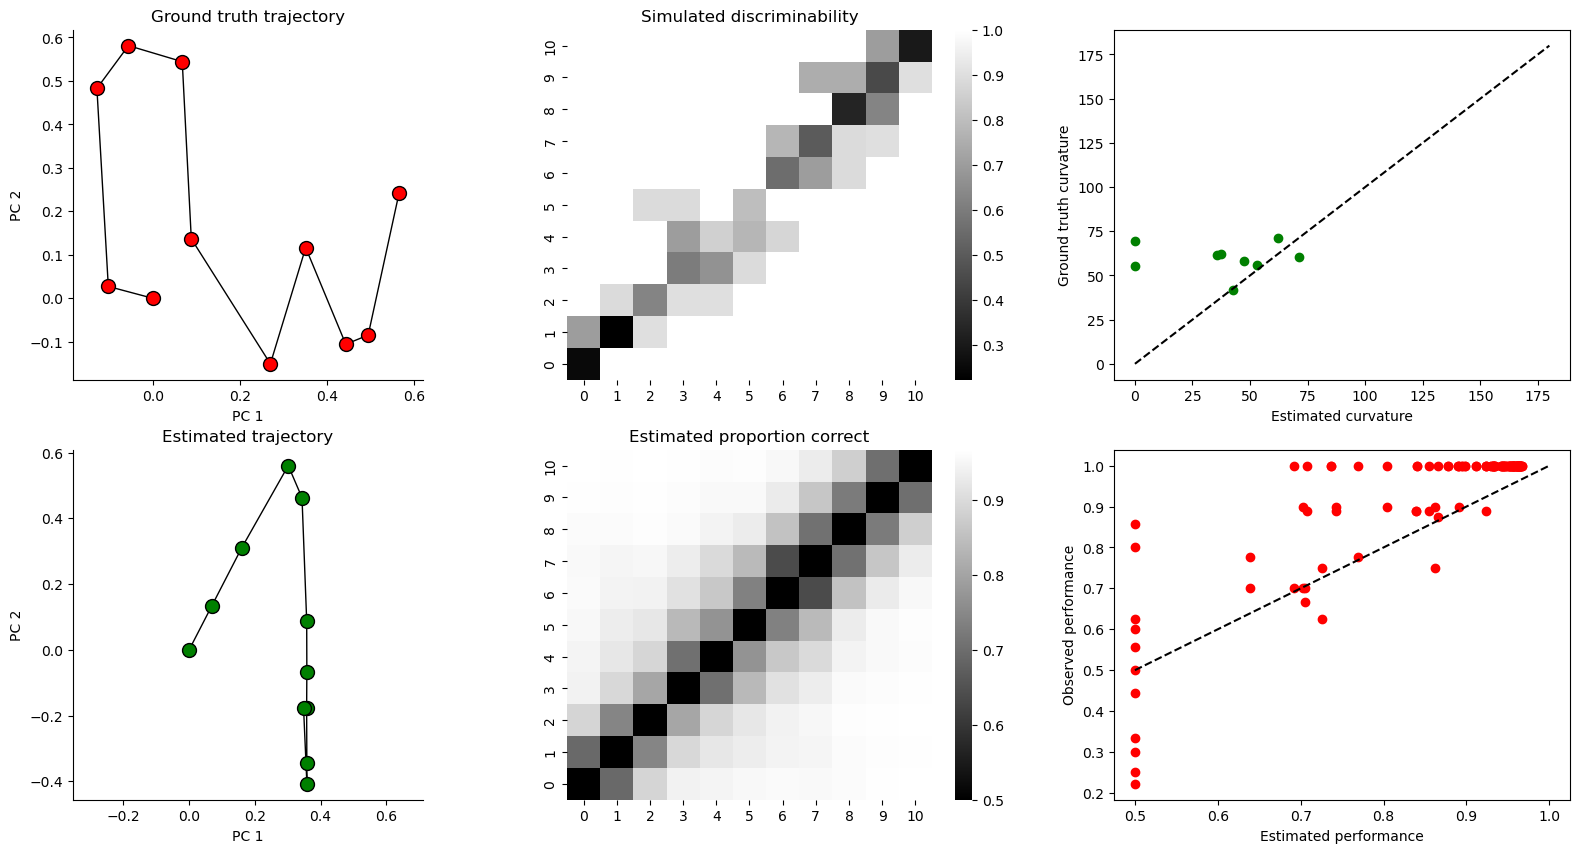

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].plot(pc_true[0, :], pc_true[1, :], '-ko', markersize=10, markerfacecolor='r', linewidth=1)
axs[0, 0].set_title('Ground truth trajectory')
axs[0, 0].set_xlabel('PC 1')
axs[0, 0].set_ylabel('PC 2')
axs[0, 0].set_box_aspect(1)  
axs[0, 0].set_aspect('equal') 
axs[0, 0].spines['top'].set_visible(False)  
axs[0, 0].spines['right'].set_visible(False)

sns.heatmap(S_list[sim_idx]['Pc_reshaped'][0, 0], ax=axs[0, 1], cmap='gray')
axs[0, 1].invert_yaxis()
axs[0, 1].set_title('Simulated discriminability')

axs[0, 2].plot(torch.flatten(torch.rad2deg(torch.mean(c, dim=0))).detach(), np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), 'go')
axs[0, 2].plot([0, 180], [0, 180], 'k--')
axs[0, 2].set_xlabel('Estimated curvature')
axs[0, 2].set_ylabel('Ground truth curvature')

axs[1, 0].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[1, 0].set_title('Estimated trajectory')
axs[1, 0].set_xlabel('PC 1')
axs[1, 0].set_ylabel('PC 2')
axs[1, 0].set_box_aspect(1)  
axs[1, 0].set_aspect('equal') 
axs[1, 0].spines['top'].set_visible(False)  
axs[1, 0].spines['right'].set_visible(False)

sns.heatmap(torch.mean(p, dim=0).detach().numpy().squeeze(), ax=axs[1, 1], cmap='gray')
axs[1, 1].invert_yaxis()
axs[1, 1].set_title('Estimated proportion correct')

axs[1, 2].plot(torch.mean(p, dim=0).flatten().detach().numpy(), S_list[sim_idx]['Pc_reshaped'][0, 0].flatten(), 'ro')
axs[1, 2].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 2].set_xlabel('Estimated performance')
axs[1, 2].set_ylabel('Observed performance')

plt.show()